In [1]:
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import glob,gc,os

In [3]:
from matplotlib.patheffects import withStroke

In [4]:
# Information for TIGRESS synthetic maps
# dust polarization maps at 353 GHz can be downloaded at https://lambda.gsfc.nasa.gov/simulation/tb_tigress_data.cfm
data_folder = '../data/allsky_maps/'

# 9 observer positions
observers = ['x0y0z0','x-256y0z0','x256y0z0',
             'x0y-256z0','x-256y-256z0','x256y-256z0',
             'x0y256z0','x-256y256z0','x256y256z0']

# 350 snapshots to process
itimes=np.arange(300,650,dtype=int)

In [5]:
# pandas and xarray are used to handle data
import pandas as pd
import xarray as xr
# seaborn is used for plotting
import seaborn as sns

In [6]:
# for |b|>30
bcut = 'b30'
with xr.open_dataset('../data/all_cls.nc') as dset:
    avg=dset.sel(leff=slice(80,120)).mean(dim='leff')

ratio=xr.Dataset()
ratio['EEBB'] = avg['EE']/avg['BB']
ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])

# convert to pandas dataframe to use seaborn pairplot
dlist=[]
for i,obs in enumerate(observers):
    df = ratio.sel(observer=i).to_array().to_pandas()
    ob=pd.Series(np.zeros_like(ratio.time)+i+1,index=ratio.time,name='observer',dtype=int)
    dlist.append(df.append(ob).T)

df=pd.concat(dlist,ignore_index=True)


# for |b|>60
bcut = 'b60'
with xr.open_dataset('../data/all_cls.b60.nc') as dset:
    avg=dset.sel(leff=slice(80,120)).mean(dim='leff')

ratio=xr.Dataset()
ratio['EEBB'] = avg['EE']/avg['BB']
ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])

# convert to pandas dataframe to use seaborn pairplot
dlist=[]
for i,obs in enumerate(observers):
    df_b60 = ratio.sel(observer=i).to_array().to_pandas()
    ob=pd.Series(np.zeros_like(ratio.time)+i+1,index=ratio.time,name='observer',dtype=int)
    dlist.append(df_b60.append(ob).T)

df_b60=pd.concat(dlist,ignore_index=True)

# distribution from all maps with Spearman's correlation coefficient

In [7]:
labels_dict = dict(EEBB=r'$EE/BB$', rTE=r'$r^{TE}$', rTB=r'$r^{TB}$', rEB=r'$r^{EB}$',)
def pair_plot_with_corr(df_selected, labels = [r'$EE/BB$',r'$r^{TE}$',r'$r^{TB}$',r'$r^{EB}$'], corr_method='spearman'):
    g = sns.PairGrid(df_selected,diag_sharey=False,corner=True)
    g.map_lower(sns.scatterplot, s=15)
    g.map_diag(sns.distplot,kde=False)

    if labels is not None:
        for ax,lab in zip(g.axes[1:,0],labels[1:]):
            ax.set_ylabel(lab)
        for ax,lab in zip(g.axes[-1,:],labels[:]):
            ax.set_xlabel(lab)
        
    corr = df_selected.corr(method=corr_method)
    for i,xv in enumerate(g.x_vars):
        for j,yv in enumerate(g.y_vars[i+1:]):
            plt.sca(g.axes[j+i+1,i])
            plt.annotate(r'$\rho = {:.2f}$'.format(corr[xv][yv]),(0.95,0.05),
                         ha='right',va='bottom',xycoords='axes fraction',
                         path_effects=[withStroke(foreground='w',linewidth=3)]
                        )
            print(xv,yv,corr[xv][yv])
        plt.sca(g.axes[i,i])
        q=df_selected[xv].quantile([0.16,0.5,0.84])
        dql=(q[0.16]-q[0.5])
        dqu=(q[0.84]-q[0.5])
        plt.title(labels_dict[xv]+r'$ = {:.2f}^{{{:.2f}}}_{{{:.2f}}}$'.format(q[0.5],dqu,dql))
    for i,xv in enumerate(g.x_vars):
        plt.sca(g.axes[-1,i])
        if (xv == 'EEBB'): plt.xlim(0,3)
        elif (xv == 'rTE'): plt.xlim(-0.55,0.55)
        elif (xv == 'rTB'): plt.xlim(-0.55,0.55)
        elif (xv == 'rEB'): plt.xlim(-0.55,0.55)
    for i,yv in enumerate(g.y_vars[1:]):
        plt.sca(g.axes[i+1,0])
        if (yv == 'EEBB'): plt.ylim(0,3)
        elif (yv == 'rTE'): plt.ylim(-0.55,0.55)
        elif (yv == 'rTB'): plt.ylim(-0.55,0.55)
        elif (yv == 'rEB'): plt.ylim(-0.55,0.55)
    return g

In [8]:
corr_method='spearman'

EEBB rTE 0.6273540288398642
EEBB rTB -0.023540052810908874
EEBB rEB 0.03039332982164118
rTE rTB -0.02334896385237131
rTE rEB 0.01130642497179294
rTB rEB 0.2731036351494383


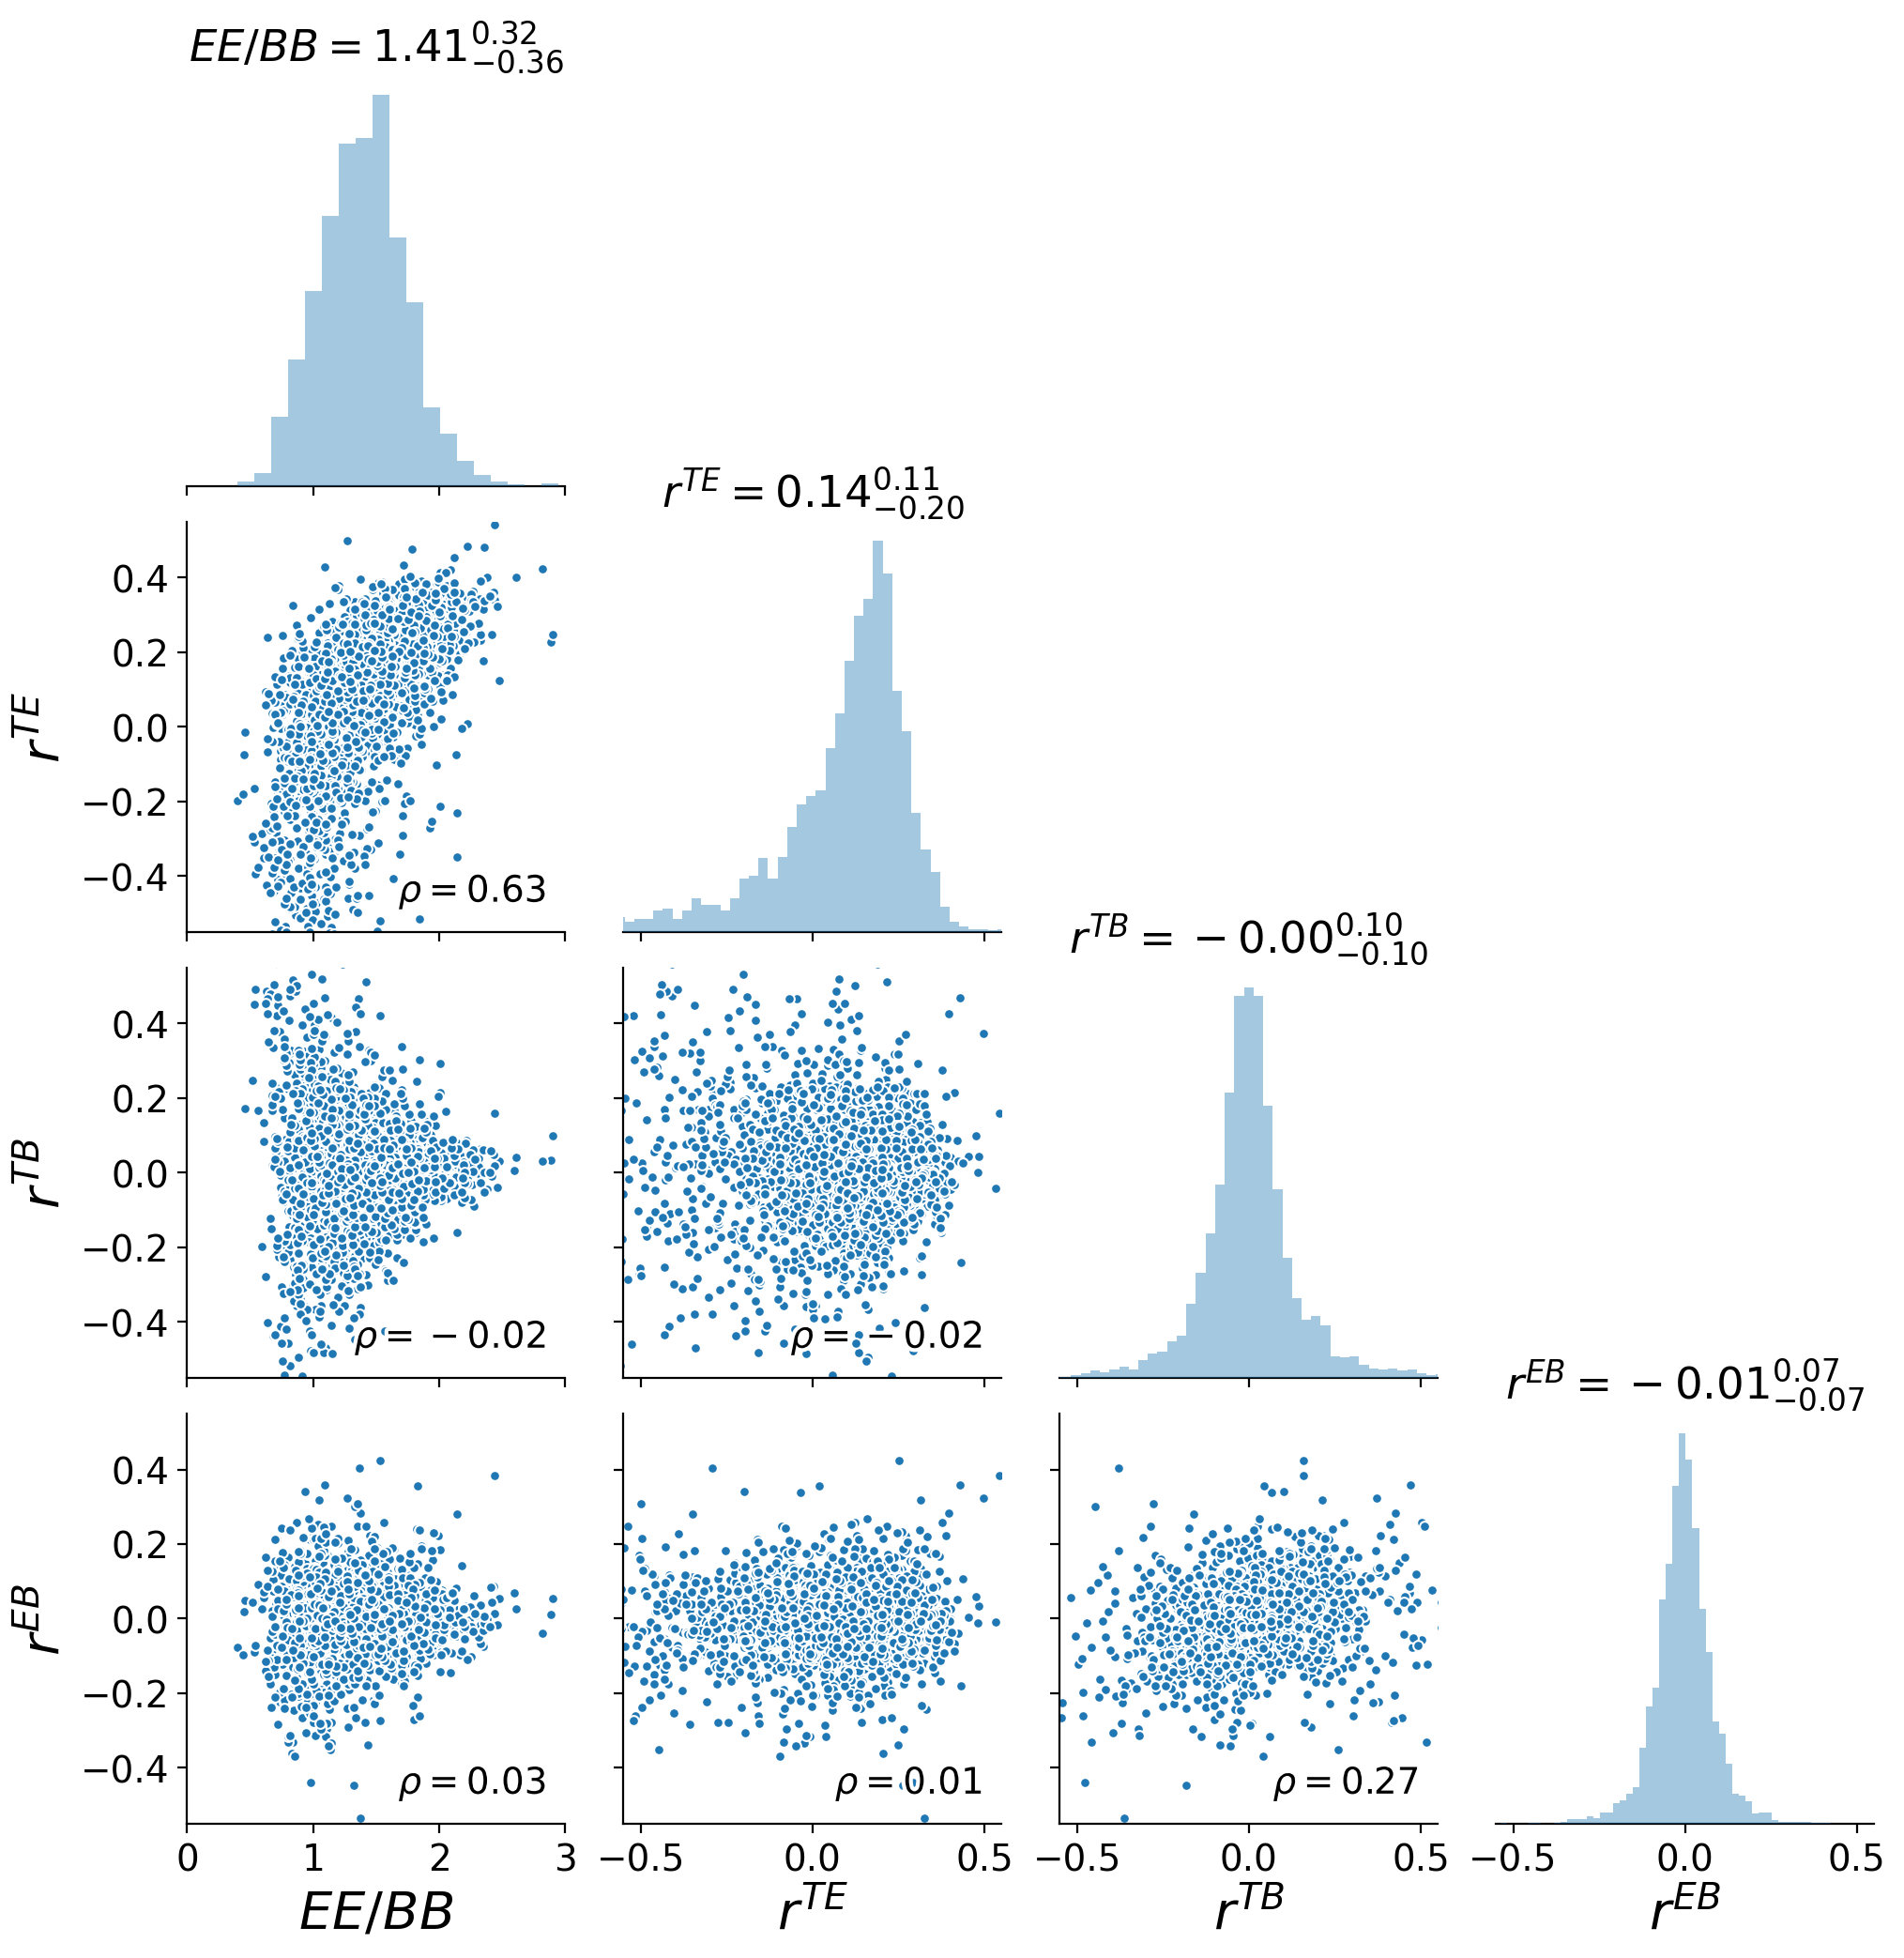

In [9]:
with plt.style.context({'figure.dpi':200,'font.size':14,'axes.labelsize':'x-large'}):
    df_selected = df[['EEBB','rTE','rTB','rEB']]
    g = pair_plot_with_corr(df_selected,corr_method=corr_method)
    g.savefig('../figures/all_corr_{}_{}.png'.format(corr_method,bcut),bbox_inches='tight',dpi=200)

# Correlations in maps with strong TE or TB

rEB rTB 0.8044218287173144 0.0026690884676967724
rTB rEB 0.5317232160556369 -0.0035135556440368245
rEB rTB -0.9199494126613024 0.03388613935102151
rTB rEB -0.19143255295263767 -0.004000546156148546
rEB rTE 1.2923370075830825 -0.0944456549350359
rTE rEB 0.33945864976620654 0.043739396220369695
rEB rTE -0.8378842547544448 -0.08701780400764766
rTE rEB -0.29856085413735206 -0.0699481032416504


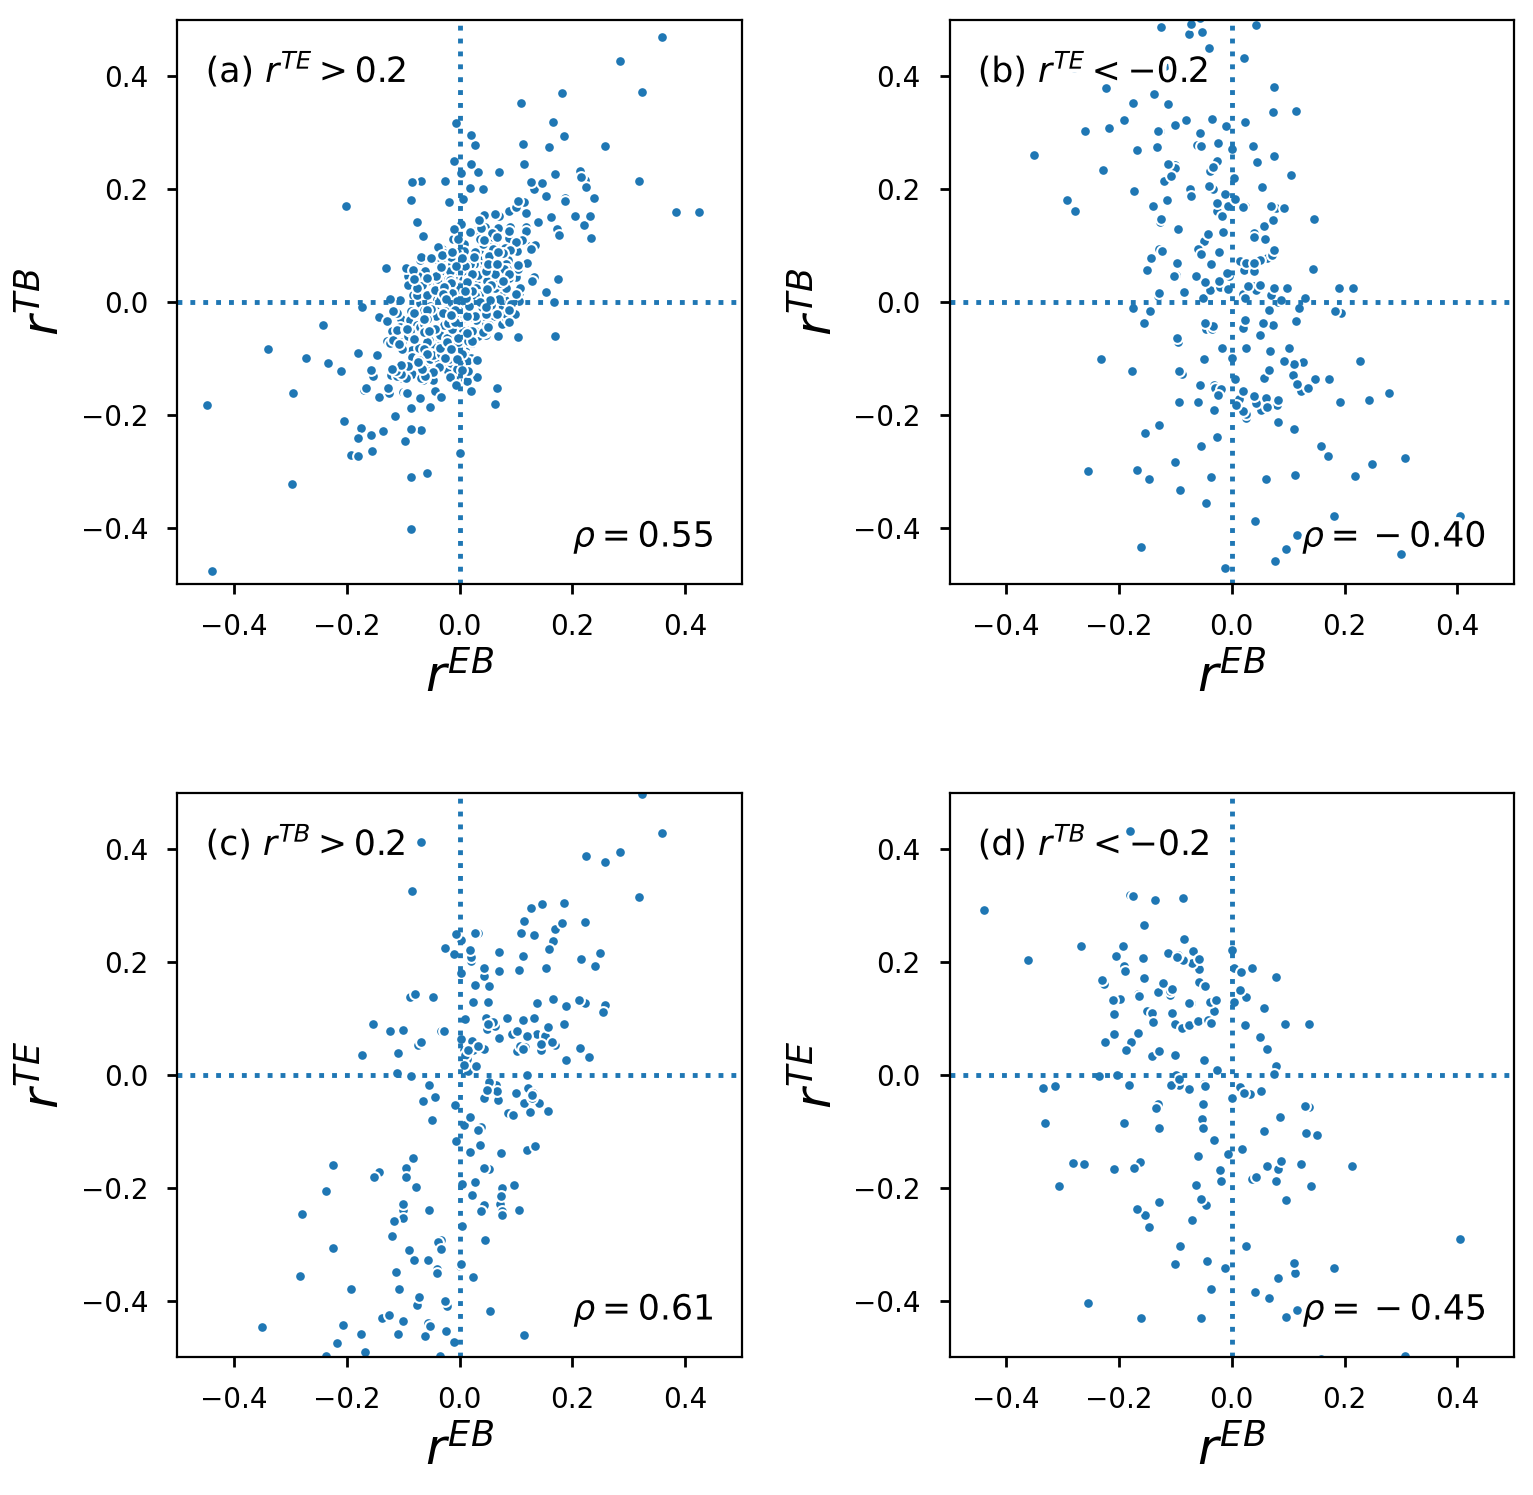

In [10]:
from scipy import stats

with plt.style.context(['seaborn-notebook',{'figure.dpi':200,'font.size':18,'axes.labelsize':'medium'}],after_reset=True):
    dfpTE = df.where(df.rTE>0.2)[['rTB','rEB']]
    dfnTE = df.where(df.rTE<-0.2)[['rTB','rEB']]
    dfpTB = df.where(df.rTB>0.2)[['rTE','rEB']]
    dfnTB = df.where(df.rTB<-0.2)[['rTE','rEB']]
    fig,axes = plt.subplots(2,2,figsize=(8,8))
    for ax,x,y,df_,lab in zip(axes.flat,
                             ['rEB','rEB','rEB','rEB'],
                             ['rTB','rTB','rTE','rTE'],
                             [dfpTE,dfnTE,dfpTB,dfnTB],
                              ['(a) $r^{TE}>0.2$','(b) $r^{TE}<-0.2$','(c) $r^{TB}>0.2$','(d) $r^{TB}<-0.2$']
                             ):
        plt.sca(ax)
        sns.scatterplot(x,y,data=df_, s=15)
#         sns.regplot(x,y,data=df_,scatter_kws=dict(alpha=0.5, s=15))
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_[x].dropna(),df_[y].dropna())
        print(x,y,slope,intercept)
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_[y].dropna(),df_[x].dropna())
        print(y,x,slope,intercept)

        corr = df_.corr(method=corr_method)

        plt.annotate(lab,(0.05,0.95),ha='left',va='top',xycoords='axes fraction',fontsize='x-small',
                     path_effects=[withStroke(foreground='w',linewidth=3)])
        plt.annotate(r'$\rho={:.2f}$'.format(corr[x][y]),(0.95,0.05),
                     ha='right',va='bottom',xycoords='axes fraction',fontsize='x-small',
                     path_effects=[withStroke(foreground='w',linewidth=3)])
        plt.axhline(0,ls=':')
        plt.axvline(0,ls=':')
        plt.xlim(-0.5,0.5)
        plt.ylim(-0.5,0.5)
#         plt.plot([-0.3,0.3],[-0.6,0.6])
#         plt.plot([-0.3,0.3],[0.6,-0.6])
        plt.xlabel(labels_dict[x])
        plt.ylabel(labels_dict[y])
        ax.set_aspect('equal')
    plt.tight_layout()
    fig.savefig('../figures/correlation_{}.png'.format(corr_method),bbox_inches='tight',dpi=200)

# Plank-like selection and linear regression

638 rTB rEB 0.5780746601367147 -0.002488889948050205


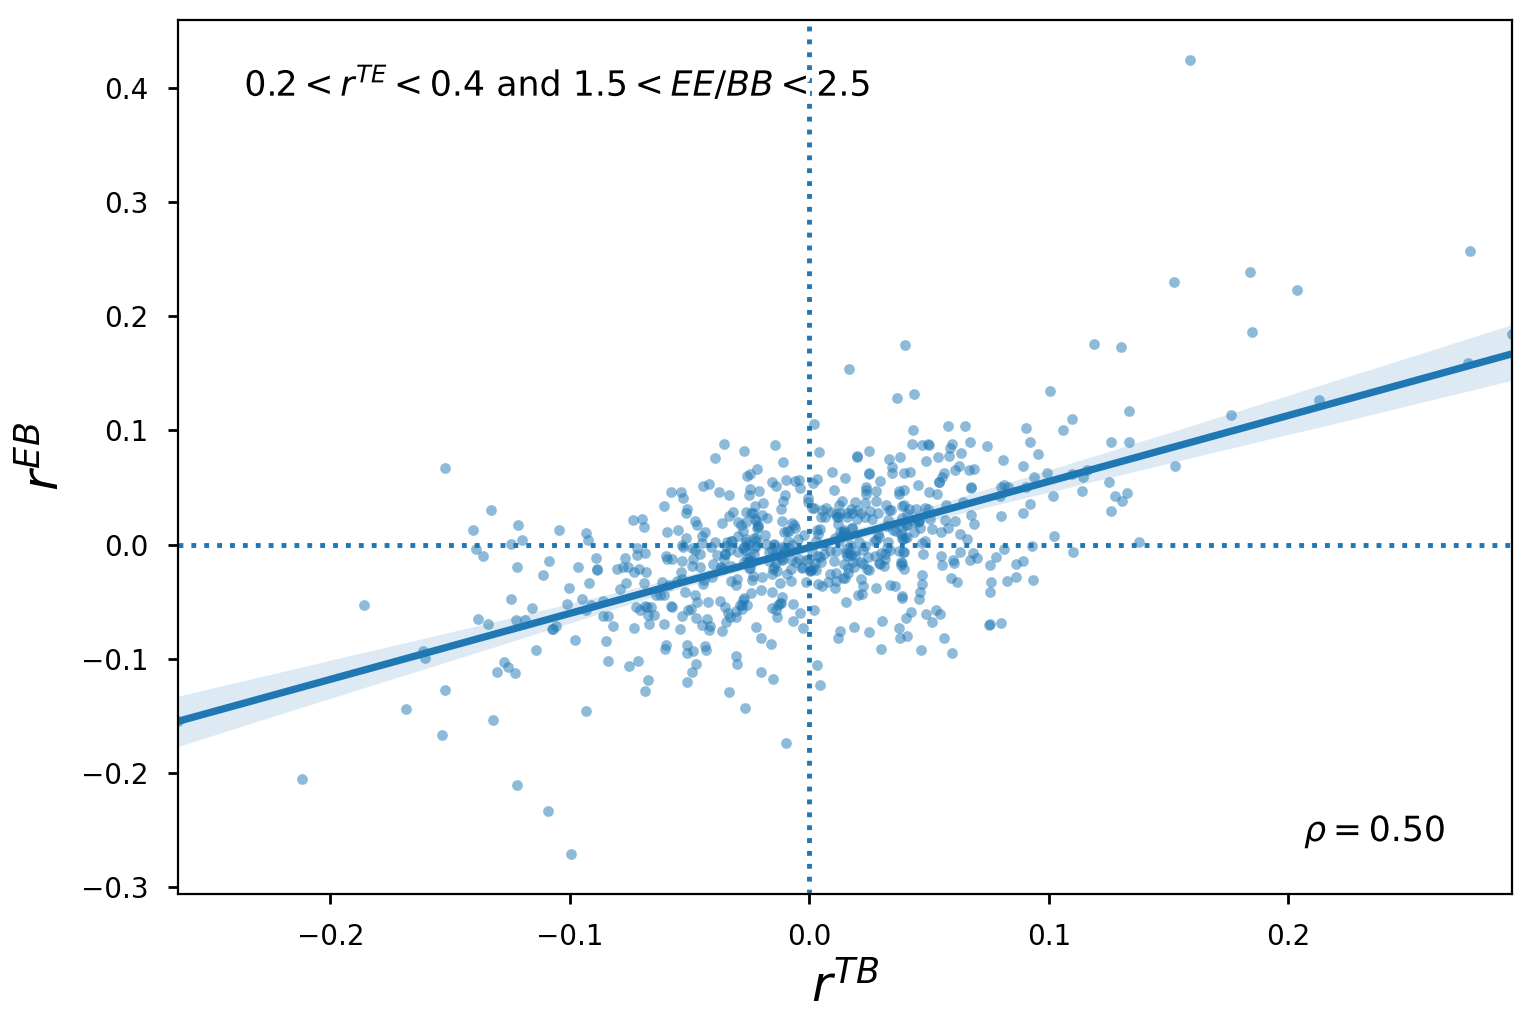

In [11]:
from scipy import stats

with plt.style.context(['seaborn-notebook',{'figure.dpi':200,'font.size':18,'axes.labelsize':'medium'}],after_reset=True):
    dfpl = df.where((df.rTE>0.2) & (df.rTE<0.4) & (df.EEBB>1.5) & (df.EEBB<2.5))[['rTB','rEB']]
#     sns.scatterplot(x,y,data=df_, s=15)
    y='rEB'
    x='rTB'
    sns.regplot(x,y,data=dfpl,scatter_kws=dict(alpha=0.5, s=15))
    slope, intercept, r_value, p_value, std_err = stats.linregress(dfpl[x].dropna(),dfpl[y].dropna())
    print(len(dfpl.dropna()),x,y,slope,intercept)

    corr = dfpl.corr(method=corr_method)

    plt.annotate(r'$0.2<r^{TE}<0.4\,\,{\rm and}\,\,1.5<EE/BB<2.5$',(0.05,0.95),ha='left',va='top',xycoords='axes fraction',fontsize='x-small',
                 path_effects=[withStroke(foreground='w',linewidth=3)])
    plt.annotate(r'$\rho={:.2f}$'.format(corr[x][y]),(0.95,0.05),
                 ha='right',va='bottom',xycoords='axes fraction',fontsize='x-small',
                 path_effects=[withStroke(foreground='w',linewidth=3)])
    plt.axhline(0,ls=':')
    plt.axvline(0,ls=':')
#     plt.xlim(-0.5,0.5)
#     plt.ylim(-0.5,0.5)
#         plt.plot([-0.3,0.3],[-0.6,0.6])
#         plt.plot([-0.3,0.3],[0.6,-0.6])
    plt.xlabel(labels_dict[x])
    plt.ylabel(labels_dict[y])
#         ax.set_aspect('equal')
    plt.tight_layout()
    fig.savefig('../figures/correlation_planck.png',bbox_inches='tight',dpi=200)

971 rTB rEB 0.49092764856020416 -0.0035386701572585723


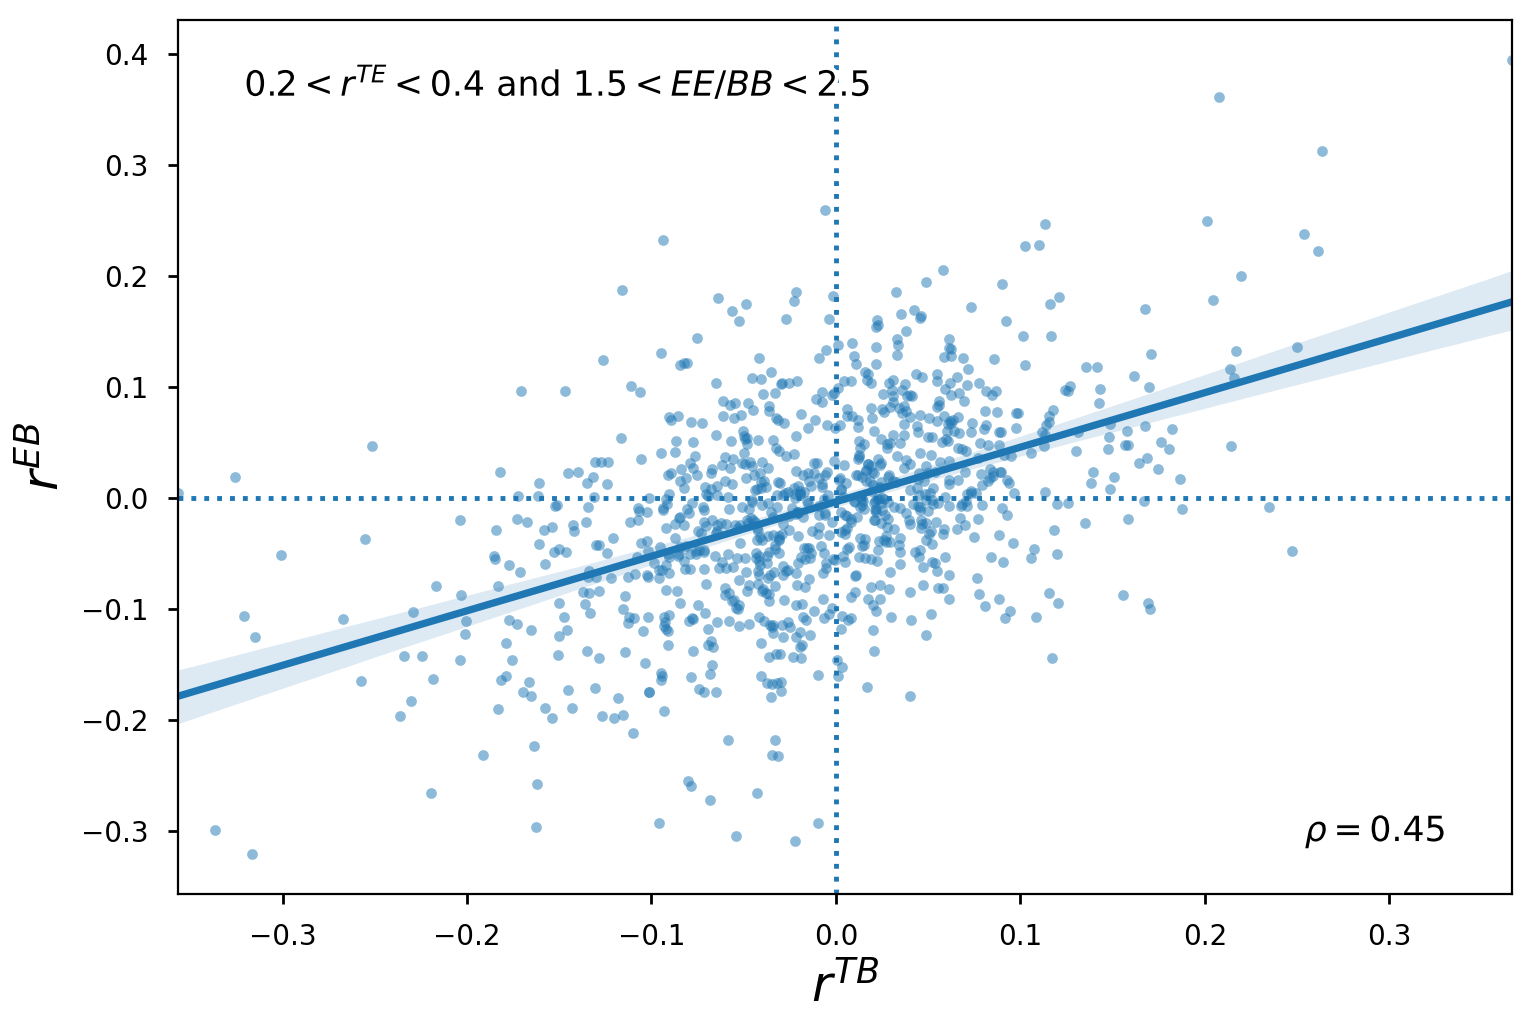

In [12]:
from scipy import stats

with plt.style.context(['seaborn-notebook',{'figure.dpi':200,'font.size':18,'axes.labelsize':'medium'}],after_reset=True):
    dfpl = df_b60.where((df_b60.rTE>0.2) & (df_b60.rTE<0.4) & 
                        (df_b60.EEBB>1.5) & (df_b60.EEBB<2.5))[['rTB','rEB']]
#     sns.scatterplot(x,y,data=df_, s=15)
    y='rEB'
    x='rTB'
    sns.regplot(x,y,data=dfpl,scatter_kws=dict(alpha=0.5, s=15))
    slope, intercept, r_value, p_value, std_err = stats.linregress(dfpl[x].dropna(),dfpl[y].dropna())
    print(len(dfpl.dropna()),x,y,slope,intercept)

    corr = dfpl.corr(method=corr_method)

    plt.annotate(r'$0.2<r^{TE}<0.4\,\,{\rm and}\,\,1.5<EE/BB<2.5$',(0.05,0.95),ha='left',va='top',xycoords='axes fraction',fontsize='x-small',
                 path_effects=[withStroke(foreground='w',linewidth=3)])
    plt.annotate(r'$\rho={:.2f}$'.format(corr[x][y]),(0.95,0.05),
                 ha='right',va='bottom',xycoords='axes fraction',fontsize='x-small',
                 path_effects=[withStroke(foreground='w',linewidth=3)])
    plt.axhline(0,ls=':')
    plt.axvline(0,ls=':')
#     plt.xlim(-0.5,0.5)
#     plt.ylim(-0.5,0.5)
#         plt.plot([-0.3,0.3],[-0.6,0.6])
#         plt.plot([-0.3,0.3],[0.6,-0.6])
    plt.xlabel(labels_dict[x])
    plt.ylabel(labels_dict[y])
#         ax.set_aspect('equal')
    plt.tight_layout()
    fig.savefig('../figures/correlation_planck_b60.png',bbox_inches='tight',dpi=200)